# Projet Géoscience:

## Préliminaire:

Le modèle que l'on va mettre en place se découpe en 2 modèles:
- Un qui détecte les types de roches sur un point précis
- Un qui détecte les changement de facies

Le modèle final "peindra" le 2ème modèle en mettant la roche majoritairement prédite entre 2 changement de facies

## Pourquoi cette idée:

A la base on avait testé le modèle de base avec SVM en prenant en compte les dérivés:

![SVM 42 % précision](resultat/Deriv%C3%A9%20resultat%2042%25.png)

Grâce à sa on a eu l'idée de séparer les deux.



# Modele 1: Détection des roches

## Mise en place des données:

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn import svm
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable


data = pd.read_csv("training_data.csv")
TOADD = []
old_features = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE']

def lissage(attribut):
    data["mean_"+attribut] = data[attribut].rolling(window=4).mean()
    data["mean_"+attribut][0] = data[attribut][3]
    data["mean_"+attribut][1] = data[attribut][3]
    data["mean_"+attribut][2] = data[attribut][3]

def derivate(attribut):
    data["der_"+attribut] = data[attribut].diff()
    data["der_"+attribut][0] = data["der_" + attribut][1]

def new_features(method):
    global TOADD
    if method == "lissage":
        features = old_features.copy(
        ) + ['mean_GR', 'mean_ILD_log10', 'mean_DeltaPHI', 'mean_PHIND', 'mean_PE']
        TOADD = ['mean_GR', 'mean_ILD_log10',
                    'mean_DeltaPHI', 'mean_PHIND', 'mean_PE']
    if method == 'derivate':
        features = old_features.copy(
        ) + ['der_GR', 'der_ILD_log10', 'der_DeltaPHI', 'der_PHIND', 'der_PE']
        TOADD = ['der_GR', 'der_ILD_log10',
                    'der_DeltaPHI', 'der_PHIND', 'der_PE']
    return features

## Détails:

On a plusieurs fonctions qui nous ont été utile pour tester différent modèle.
### Exemple: SVM avec lissage des données (44% précision):

![Précision de 58%](resultat/moyenne%20resultat%2044%25.png)

## Construction du réseau de neurones:


In [2]:

old_features = ['GR', 'ILD_log10', 'DeltaPHI','PHIND','PE']
features = old_features.copy()


"""
SI ON VEUT FAIRE UN PRE-TRAITEMENT
def traitement(fun_trait):
    for feature in old_features:
        fun_trait(feature)

traitement(lissage)
print(data)"""
    
    
test_well = data[data['Well Name'] == 'SHANKLE']
data = data[data['Well Name'] != 'SHANKLE']


feature_vectors = data[features]
facies_labels = data['Facies']

scaler = StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)


In [ ]:
X_train, X_cv, y_train, y_cv = train_test_split(scaled_features, facies_labels,test_size=0.05, random_state=42)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

clf = keras.Sequential()

clf.add(keras.layers.Dense(units=64, activation='relu', input_dim=5))
clf.add(keras.layers.Dropout(0.2))
clf.add(keras.layers.Dense(units=32, activation='relu'))
clf.add(keras.layers.Dropout(0.2))
clf.add(keras.layers.Dense(units=16, activation='relu'))
clf.add(keras.layers.Dropout(0.2))
clf.add(keras.layers.Dense(units=9, activation='softmax'))

clf.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

X_train = (X_train)/X_train.max()
y_train = keras.utils.to_categorical(y_train-1, num_classes=9)

clf.fit(X_train, y_train, epochs=80, batch_size=300);

## Choix des paramètres:

Une couche d'entrée à 64 neurones
Deux couches cachées à 32 et 16 neurones

Entre elles on a en dropout à 0.2 ce qui signifie que chaque neurone a 20% de chances d'être désactivé pendant une génération pour éviter le sur-aprentissage.

Ensuite, on crée 80 générations avec un batch size de 300. On a choisi un grand nombre pour le batch-size afin d'avoir une convergence rapide et pour pouvoir mettre plus de génération. Le but au global était d'entrainer suffisamment le modèle sans sur-apprendre.

Ici on apprend pas très longtemps cela nous permet d'avoir un modèle léger qui sera ensuite amélioré par la suite avec le 2ème modèle.

## Résultat du modèle:

In [4]:


# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
data.loc[:,'FaciesLabels'] = data.apply(lambda row: label_facies(row, facies_labels), axis=1)

In [5]:
y_test = test_well['Facies']
well_features = test_well.drop(['Facies', 'Formation', 'Well Name', 'Depth', 'NM_M', 'RELPOS'], axis=1)
X_test = scaler.transform(well_features)
X_test = X_test/X_test.max()
y_pred_old = clf.predict(X_test)
y_pred = np.argmax(y_pred_old,axis=-1)+1
test_well['Prediction'] = y_pred
from sklearn.metrics import classification_report, accuracy_score
try:
    target_names = ['SS', 'CSiS', 'FSiS', 'SiSh','MS', 'WS', 'D','PS','BS']
    print("modele1:")
    cr = classification_report(y_test, y_pred,target_names=target_names)
    print(cr)
    print(accuracy_score(y_test,y_pred))
except:
    target_names = ['SS', 'CSiS', 'FSiS', 'SiSh','MS', 'WS', 'D','PS']
    print("modele1:")
    cr = classification_report(y_test, y_pred,target_names=target_names)
    print(cr)
    print(accuracy_score(y_test,y_pred))

15/15 [==============================] - 0s 2ms/step
modele1:
              precision    recall  f1-score   support

          SS       0.74      0.55      0.63        89
        CSiS       0.47      0.55      0.51        89
        FSiS       0.78      0.79      0.78       117
        SiSh       0.00      0.00      0.00         7
          MS       0.00      0.00      0.00        19
          WS       0.56      0.76      0.65        71
           D       1.00      0.18      0.30        17
          PS       0.54      0.62      0.58        40
          BS       0.00      0.00      0.00         0

    accuracy                           0.61       449
   macro avg       0.45      0.38      0.38       449
weighted avg       0.62      0.61      0.60       449

0.6080178173719376


/home/leo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leo/.local/lib/python3.10/site-packages/sklearn/

In [6]:
def compare_facies_plot(logs, compadre, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[compadre].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(9, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel(compadre)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)


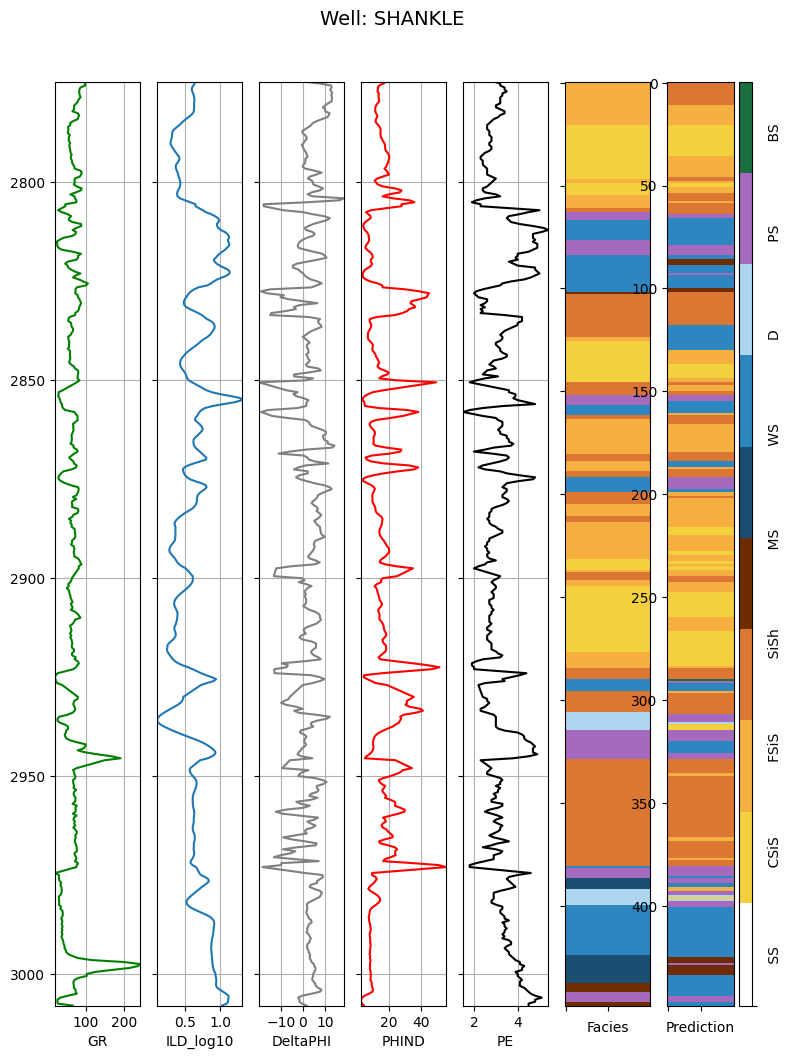

In [7]:
compare_facies_plot(test_well, 'Prediction', facies_colors)
plt.show()